In [1]:
ls ../test-data/EQY_US_ALL_BBO_201402/

EQY_US_ALL_BBO_20140203.h5       EQY_US_ALL_BBO_20140213.h5
EQY_US_ALL_BBO_20140203.old.zip  EQY_US_ALL_BBO_20140213.old.zip
EQY_US_ALL_BBO_20140203.zip      EQY_US_ALL_BBO_20140213.zip
EQY_US_ALL_BBO_20140204.h5       EQY_US_ALL_BBO_20140214.h5
EQY_US_ALL_BBO_20140204.old.zip  EQY_US_ALL_BBO_20140214.old.zip
EQY_US_ALL_BBO_20140204.zip      EQY_US_ALL_BBO_20140214.zip
EQY_US_ALL_BBO_20140205.h5       EQY_US_ALL_BBO_20140218.h5
EQY_US_ALL_BBO_20140205.old.zip  EQY_US_ALL_BBO_20140218.zip
EQY_US_ALL_BBO_20140205.zip      EQY_US_ALL_BBO_20140219.h5
EQY_US_ALL_BBO_20140206.h5       EQY_US_ALL_BBO_20140219.zip
EQY_US_ALL_BBO_20140206.old.zip  EQY_US_ALL_BBO_20140220.h5
EQY_US_ALL_BBO_20140206.zip      EQY_US_ALL_BBO_20140220.zip
EQY_US_ALL_BBO_20140207.h5       EQY_US_ALL_BBO_20140221.h5
EQY_US_ALL_BBO_20140207.old.zip  EQY_US_ALL_BBO_20140221.zip
EQY_US_ALL_BBO_20140207.zip      EQY_US_ALL_BBO_20140224.h5
EQY_US_ALL_BBO_20140210.h5       EQY_US_ALL_BBO_20140224.zip
EQY_US_ALL_BBO_20140210

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import tables as tb

In [3]:
fname = '../test-data/EQY_US_ALL_BBO_201402/EQY_US_ALL_BBO_20140206.h5'

In [5]:
# by default, this will be read-only
taq_tb = tb.open_file(fname)

In [5]:
rec_counts = {curr._v_pathname: len(curr) 
              for curr in taq_tb.walk_nodes('/', 'Table')}

In [6]:
# What's our biggest table? (in bytes)
max(rec_counts.values()) * 91 / 2 ** 20 # I think it's 91 bytes...

893.6236171722412

Anyway, under a gigabyte. So, nothing to worry about even if we have 24 cores.

In [7]:
# But what symbol is that?
max_sym = None
max_rows = 0
for sym, rows in rec_counts.items():
    if rows > max_rows:
        max_rows = rows
        max_sym = sym

In [8]:
max_sym, max_rows

('/SPY/no_suffix', 10297058)

Interesting... the S&P 500 ETF

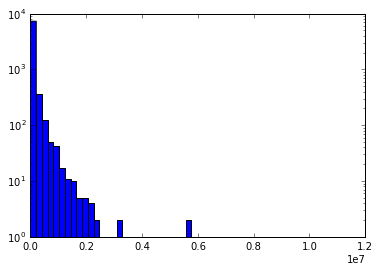

In [9]:
# Most symbols also have way less rows - note this is log xvals
plt.hist(list(rec_counts.values()), bins=50, log=True)
plt.show()

## Doing some compute

We'll use a "big" table to get some sense of timings

In [6]:
spy = taq_tb.get_node('/SPY/no_suffix')

In [7]:
spy[0]['Bid_Price']

174.5

In [18]:
# PyTables is record oriented...
%timeit np.mean(list(x['Bid_Price'] for x in spy.iterrows()))

1 loop, best of 3: 2.55 s per loop


In [59]:
np.mean(list(x['Bid_Price'] for x in spy.iterrows()))

176.82760773125673

In [47]:
spy_bp = spy.cols.Bid_Price

In [34]:
# not sure this works...
np.mean(spy_bp)

KeyboardInterrupt: 

In [48]:
spy_bp.sum()

AttributeError: 'Column' object has no attribute 'sum'

In [51]:
# But it can use numexpr
expr = tb.Expr('sum(spy_bp)')

In [61]:
%timeit result = expr.eval().mean()

1 loop, best of 3: 3.62 s per loop


In [60]:
tb.Expr('spy_bp').eval().mean()

176.82760773125673

In [1]:
import h5py
import dask.dataframe as dd

In [4]:
spy = h5py.File(fname)['/SPY/no_suffix']

In [6]:
spy

TypeError: No NumPy equivalent for TypeTimeID exists

In [5]:
spy_dask = dd.from_array(spy)

TypeError: No NumPy equivalent for TypeTimeID exists

In [10]:
mean_job = spy_dask['Bid_Price'].min()

In [ ]:
mean_job.compute()

### To load with Pandas, you need to close the pytables session

In [41]:
taq_tb.close()

In [42]:
# Pandas has optimizations it likes to do with 
%timeit spy_df = pd.read_hdf(fname, '/SPY/no_suffix')

KeyboardInterrupt: 

In [43]:
# This is fast, but loading is slow...
%timeit spy_df.Bid_Price.mean()

10 loops, best of 3: 87.1 ms per loop
